<a href="https://colab.research.google.com/github/SalarShafiee/ML-Projects/blob/main/ViT%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

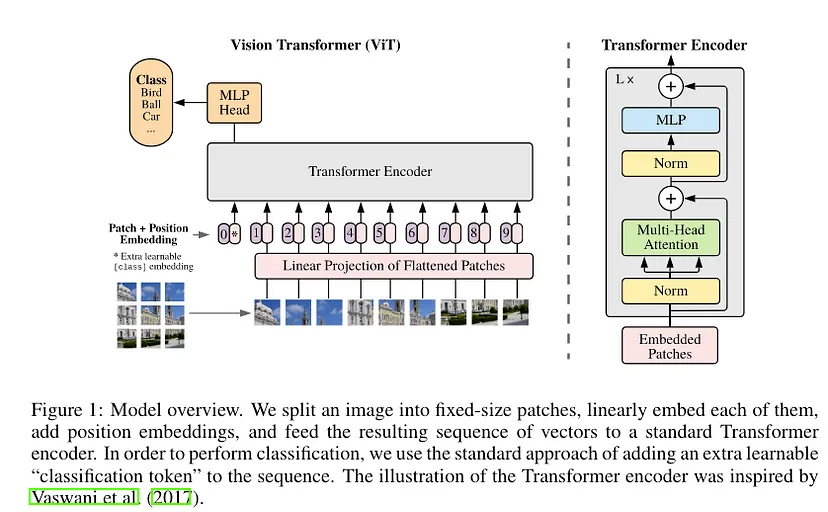

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [36]:
image=tf.keras.preprocessing.image.load_img("/content/WhatsApp Image 2024-10-20 at 13.32.24.jpeg",target_size=(144,144))
print (image)

<PIL.Image.Image image mode=RGB size=144x144 at 0x79A99FFD7730>


In [37]:
imageArray=tf.keras.preprocessing.image.img_to_array(image)

In [38]:
imageArray=imageArray[tf.newaxis,...]
print (imageArray.shape)

(1, 144, 144, 3)


In [39]:
"""#Patch Embedding"""

class PatchEmbedding(tf.keras.layers.Layer):
  def __init__(self , size , num_of_patches , projection_dim):
    super().__init__()

    self.size = size
    self.num_of_patches = num_of_patches + 1
    self.projection_dim = projection_dim

    self.projection = tf.keras.layers.Dense(projection_dim)

    self.clsToken = tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)

    self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)


  def call(self , inputs):
    patches = tf.image.extract_patches(inputs , sizes=[1 , self.size , self.size , 1] , strides=[1 , self.size , self.size , 1] , rates=[1 , 1 , 1 , 1] ,  padding="VALID")
    patches = tf.reshape(patches , (tf.shape(inputs)[0] , -1 , self.size * self.size * 3))
    patches = self.projection(patches)

    clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)

    patches = tf.concat((clsToken , patches) , axis=1)

    positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
    positionalEmbedding = self.positionalEmbedding(positions)

    patches = patches + positionalEmbedding

    return patches



In [40]:
Embedding=PatchEmbedding(16,81,128)(imageArray)
Embedding.shape

TensorShape([1, 82, 128])

In [41]:
"""#Each Layer of Transformer Encoder"""
class TransformerLayer(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.mha = tf.keras.layers.MultiHeadAttention(heads , d_model//heads , dropout=dropout_rate)

    self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.mlp = tf.keras.Sequential([
                                    tf.keras.layers.Dense(d_model * mlp_rate , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate),
                                    tf.keras.layers.Dense(d_model , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate)
    ])

  def call(self , inputs , training=True):
    out_1 = self.layernorm_1(inputs)
    out_1 = self.mha(out_1 , out_1 , training=training)
    out_1 = inputs + out_1

    out_2 = self.layernorm_2(out_1)
    out_2 = self.mlp(out_2 , training=training)
    out_2 = out_1 + out_2

    return out_2

In [42]:
"""#Transformer Encoder"""

class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
    super().__init__()

    self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

  def call(self , inputs , training=True):
    x = inputs

    for layer in self.encoders:
      x = layer(x , training=training)

    return x


In [43]:
"""#Vision Transformer"""

class ViT(tf.keras.Model):
  def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1 , prediction_dropout=0.3):
    super().__init__()

    self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
    self.encoder = TransformerEncoder(d_model , heads , mlp_rate , num_layers , dropout_rate)

    self.prediction = tf.keras.Sequential([
                                           tf.keras.layers.Dropout(prediction_dropout),
                                           tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                           tf.keras.layers.Dropout(prediction_dropout),
                                           tf.keras.layers.Dense(num_classes , activation="softmax")
    ])

  def call(self , inputs , training=True):
    patches = self.patchEmbedding(inputs)

    encoderResult = self.encoder(patches , training=training)

    clsResult = encoderResult[: , 0 , :]

    prediction = self.prediction(clsResult , training=training)

    return prediction


In [44]:

"""#Complete Model"""

vitClassifier = ViT(
                    num_classes=100,
                    patch_size=16,
                    num_of_patches=(224//16)**2,
                    d_model=128,
                    heads=2,
                    num_layers=4,
                    mlp_rate=2,
                    dropout_rate=0.1)

#Train ViT on Cifar10

In [45]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar100.load_data()

In [46]:
preprocessingmodel=tf.keras.Sequential([
                                    tf.keras.layers.Normalization(),
                                    tf.keras.layers.Resizing(144,144)
])

preprocessingmodel.layers[0].adapt(x_train)

In [47]:
augmentationmodel=tf.keras.Sequential([
                                    tf.keras.layers.RandomFlip("horizontal"),
                                    tf.keras.layers.RandomZoom(0.2)
])

In [48]:
def convert_to_dataset (data, batch_size, shuffle=False, augment=False):
  dataset = tf.data.Dataset.from_tensor_slices(data)
  dataset=dataset.map(lambda x,y: (preprocessingmodel(x)[0] , y), num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    dataset=dataset.shuffle(len(dataset))

  dataset=dataset.batch(batch_size,drop_remainder=True)


  if augment:

    dataset=dataset.map(lambda x,y: (augmentationmodel(x,training=True) , y), num_parallel_calls=tf.data.AUTOTUNE)

  return dataset.prefetch(tf.data.AUTOTUNE)

In [49]:
trainingData=convert_to_dataset((x_train,y_train),1024,shuffle=True,augment=True)
ValidationData=convert_to_dataset((x_test,y_test),1024,shuffle=False,augment=False)

In [50]:
print(trainingData)

<_PrefetchDataset element_spec=(TensorSpec(shape=(1024, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 1), dtype=tf.int64, name=None))>


In [53]:
vitClassifier = ViT(
                    num_classes=10,
                    patch_size=16,
                    num_of_patches=(144//16)**2,
                    d_model=128,
                    heads=2,
                    num_layers=4,
                    mlp_rate=2,
                    dropout_rate=0.1)

vitClassifier.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [54]:
vitClassifier.fit(trainingData,epochs=10,validation_data=ValidationData)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 559ms/step - loss: nan - sparse_categorical_accuracy: 0.0100 - val_loss: nan - val_sparse_categorical_accuracy: 0.0102
Epoch 2/10
13/48 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - loss: nan - sparse_categorical_accuracy: 0.0101

KeyboardInterrupt: 